<a href="https://colab.research.google.com/github/ishandahal/ml_model_evaluation/blob/main/Confidence_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Confidence intervals

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Using Iris data for simulation

In [2]:
from mlxtend.data import iris_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = iris_data()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15,
                                                    random_state=12345,
                                                    stratify=y)
clf = KNeighborsClassifier(n_neighbors=3,
                           algorithm='kd_tree',
                           n_jobs=1)

Setting up the Bootstrap

In [3]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []

for i in range(200):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    test_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_test_X, boot_test_y = X_train[test_idx], y_train[test_idx]

    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_test_X, boot_test_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.9552421700709434

Bootstrap sample confidence interval based on OOB estimates

In [4]:
se = np.sqrt((1. / (200-1)) * np.sum([(acc - bootstrap_train_mean)**2 
                                      for acc in bootstrap_train_accuracies]))
ci = 1.97 * se  # 1.97 based on T distribution

bootstrap_na_lower = bootstrap_train_mean - ci
bootstrap_na_upper = bootstrap_train_mean + ci

print(bootstrap_na_lower, bootstrap_na_upper)

0.900528306142954 1.0099560339989329


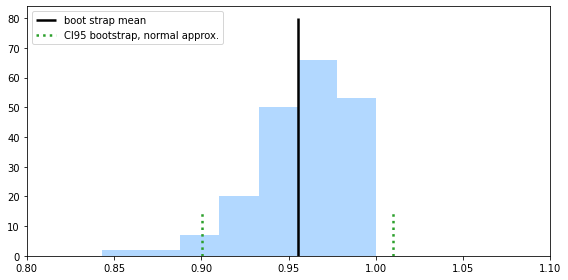

In [5]:
fig,ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle='-', label='boot strap mean')
ax.vlines(bootstrap_na_upper, [0], 15, lw=2.5, linestyle='dotted',
          label='CI95 bootstrap, normal approx.', color='C2')
ax.vlines(bootstrap_na_lower, [0], 15, lw=2.5, linestyle='dotted', color='C2')
ax.hist(bootstrap_train_accuracies, bins=7, color='#0080ff', edgecolor='none', alpha=0.3)
plt.legend(loc='upper left')
plt.xlim([0.8, 1.1])
plt.tight_layout()
plt.show()

Using the Bootstrap Percentile Method

In [6]:
bootstrap_percentile_lower = np.percentile(bootstrap_train_accuracies, 2.5)
bootstrap_percentile_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(bootstrap_percentile_lower, bootstrap_percentile_upper)

0.8977324263038549 1.0


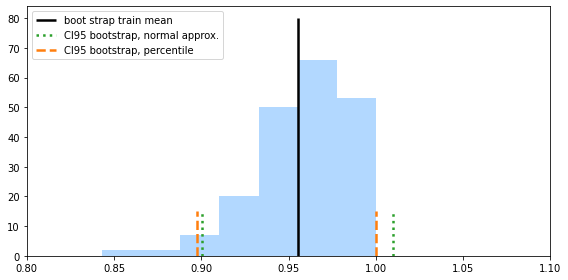

In [7]:
fig,ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle='-', label='boot strap train mean')
ax.vlines(bootstrap_na_upper, [0], 15, lw=2.5, linestyle='dotted',
          label='CI95 bootstrap, normal approx.', color='C2')
ax.vlines(bootstrap_na_lower, [0], 15, lw=2.5, linestyle='dotted', color='C2')
ax.vlines(bootstrap_percentile_upper, [0], 15, lw=2.5, linestyle='dashed',
          label='CI95 bootstrap, percentile', color='C1')
ax.vlines(bootstrap_percentile_lower, [0], 15, lw=2.5, linestyle='dashed', color='C1')
ax.hist(bootstrap_train_accuracies, bins=7, color='#0080ff', edgecolor='none', alpha=0.3)
plt.legend(loc='upper left')
plt.xlim([0.8, 1.1])
plt.tight_layout()
plt.show()

### Normal Approximation Based on the Test Set

In [8]:
clf.fit(X_train, y_train)
acc_test_na = clf.score(X_test, y_test)
ci_test_na = 1.96 * np.sqrt((acc*(1-acc)) / y_test.shape[0])

test_na_lower = acc_test_na - ci_test_na
test_na_upper = acc_test_na + ci_test_na

print(test_na_lower, test_na_upper)

0.8756568491299987 1.0373866291308709


### Booststrapping the test set predictions
Avoids retaining the model.
Useful when trainig the model is computationally expensive

In [9]:
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
acc_test = np.mean(predictions_test == y_test)

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):
    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_test[pred_idx])
    test_accuracies.append(acc_test_boot)

mean_test_accuracies = np.mean(test_accuracies)
bootstrap_lower_test = np.percentile(test_accuracies, 2.5)
bootstrap_upper_test = np.percentile(test_accuracies, 97.5)

print(bootstrap_lower_test, bootstrap_upper_test)

0.8695652173913043 1.0


### Using MLXTEND
- Normal approximation based on OOB extimates

In [10]:
from mlxtend.evaluate import bootstrap_point632_score

bootstrap_scores = bootstrap_point632_score(clf, X_train, y_train, n_splits=200,
                                            method='oob',
                                            random_seed=12345)
bootstrap_oob_mean = np.mean(bootstrap_scores)
print('Mean Bootstrap score', bootstrap_oob_mean)
print('Score Std', np.std(bootstrap_scores))

bootstrap_oob_percentile_lower = np.percentile(bootstrap_scores, 2.7)
bootstrap_oob_percentile_upper = np.percentile(bootstrap_scores, 97.5)
print(bootstrap_oob_percentile_lower, bootstrap_oob_percentile_upper)

Mean Bootstrap score 0.9552421700709434
Score Std 0.027704014141397008
0.8979591836734695 1.0


### .632 Bootstrap

In [11]:
bootstrap_scores = bootstrap_point632_score(clf,
                                            X_train, y_train,
                                            n_splits=200,
                                            random_seed=12345)
bootstrap_632_mean = np.mean(bootstrap_scores)
print("Mean Bootstrap score", bootstrap_632_mean)
print("Score Std", np.std(bootstrap_scores))

bootstrap_632_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_632_percentile_upper = np.percentile(bootstrap_scores, 97.5)
print(bootstrap_632_percentile_lower, bootstrap_632_percentile_upper)

Mean Bootstrap score 0.967105807390348
Score Std 0.016625361563867836
0.930974050743657 0.9942047244094488


### .632+ Bootstrap
This method attempts to address the optimistic bias of regular .632 Bootstrap

In [12]:
bootstrap_scores = bootstrap_point632_score(clf, X_train, y_train,
                                            n_splits=200, method='.632+',
                                            random_seed=12345)
bootstrap_632plus_mean = np.mean(bootstrap_scores)
print("Mean Bootstrap score", bootstrap_632plus_mean)
print("Score Std", np.std(bootstrap_scores))

bootstrap_632plus_percentile_lower = np.percentile(bootstrap_scores, 2.5)
bootstrap_632plus_percentile_upper = np.percentile(bootstrap_scores, 97.5)
print(bootstrap_632plus_percentile_lower, bootstrap_632plus_percentile_upper)

Mean Bootstrap score 0.9662715023612165
Score Std 0.017749021064722266
0.9279197864953824 0.9941209469907657


### Visualizing all confidence intervals

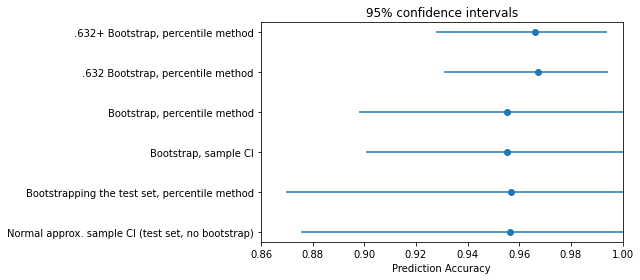

In [15]:
labels = [
    "Normal approx. sample CI (test set, no bootstrap)",
    "Bootstrapping the test set, percentile method",
    "Bootstrap, sample CI",
    "Bootstrap, percentile method",
    ".632 Bootstrap, percentile method",  
    ".632+ Bootstrap, percentile method",    
]

mean = [
    acc_test_na,
    mean_test_accuracies,
    bootstrap_train_mean,
    bootstrap_oob_mean,
    bootstrap_632_mean,
    bootstrap_632plus_mean
]

lower_error = [
    test_na_lower,
    bootstrap_lower_test,
    bootstrap_na_lower,
    bootstrap_oob_percentile_lower,
    bootstrap_632_percentile_lower,
    bootstrap_632plus_percentile_lower
]

upper_error = [
    test_na_upper,
    bootstrap_upper_test,
    bootstrap_na_upper,
    bootstrap_oob_percentile_upper,
    bootstrap_632_percentile_upper,
    bootstrap_632plus_percentile_upper    
]


asymmetric_error = [np.array(mean) - np.array(lower_error), 
                    np.array(upper_error) - np.array(mean)]


fig, ax = plt.subplots(figsize=(9, 4))
ax.errorbar(mean, np.arange(len(mean)), xerr=asymmetric_error, fmt='o')
ax.set_xlim([0.86, 1.0])
ax.set_yticks(np.arange(len(mean)))
ax.set_yticklabels(labels)
ax.set_xlabel('Prediction Accuracy')
ax.set_title('95% confidence intervals')
plt.tight_layout()
plt.savefig('CI_iris.pdf')
plt.show()